In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from IPython.display import clear_output

tqdm.pandas()
pd.options.display.max_colwidth = -1
pd.options.display.max_columns = 25

In [3]:
from dsutils.eda import *
from dsutils.stats import *
from dsutils.ml import *

In [4]:
import pickle

In [5]:
cv = pickle.load(open('BinaryCountVectorizer.pkl', 'rb'))
tv = pickle.load(open('TfidfVectorizer.pkl', 'rb'))

In [6]:
data = pd.read_csv('fuzzy_features_clean.csv')

In [7]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,abs_token_diff,avg_num_token,rel_token_diff,token_intersection,token_union,jaccard_similarity_token,...,abs_word_diff,avg_num_word,rel_word_diff,word_intersection,word_union,jaccard_similarity_word,lcs_word,lcs_word_ratio,fuzz_simple_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,2,13.0,0.153846,10,13,0.769231,...,1,6.5,0.153846,5,6,0.833333,6,0.923077,92,98,92,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,5,10.5,0.476190,4,16,0.250000,...,5,7.5,0.666667,4,11,0.363636,4,0.533333,64,91,62,89
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,4,12.0,0.333333,3,21,0.142857,...,1,5.5,0.181818,3,8,0.375000,1,0.181818,66,67,71,85
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,2,10.0,0.200000,0,19,0.000000,...,4,7.0,0.571429,0,11,0.000000,0,0.000000,44,56,15,19
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,6,10.0,0.600000,2,18,0.111111,...,5,7.5,0.666667,2,13,0.153846,1,0.133333,52,64,42,53


In [8]:
data.dropna(inplace=True)

In [9]:
from scipy.spatial.distance import hamming, cosine

In [10]:
def getweight(list_words):
    weight = 0
    for word in list_words:
        try:
            weight += tv.idf_[tv.vocabulary_[word]]
        except:
            pass
    return weight

___
<center><b>Hamming Distance</b></center>

In [11]:
q1_vect = cv.transform(data['q1_clean'])
q2_vect = cv.transform(data['q2_clean'])


         min  1st  25th  50th  75th  99th  max  mean  std
0        0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0
1        0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0
overall  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   0.0


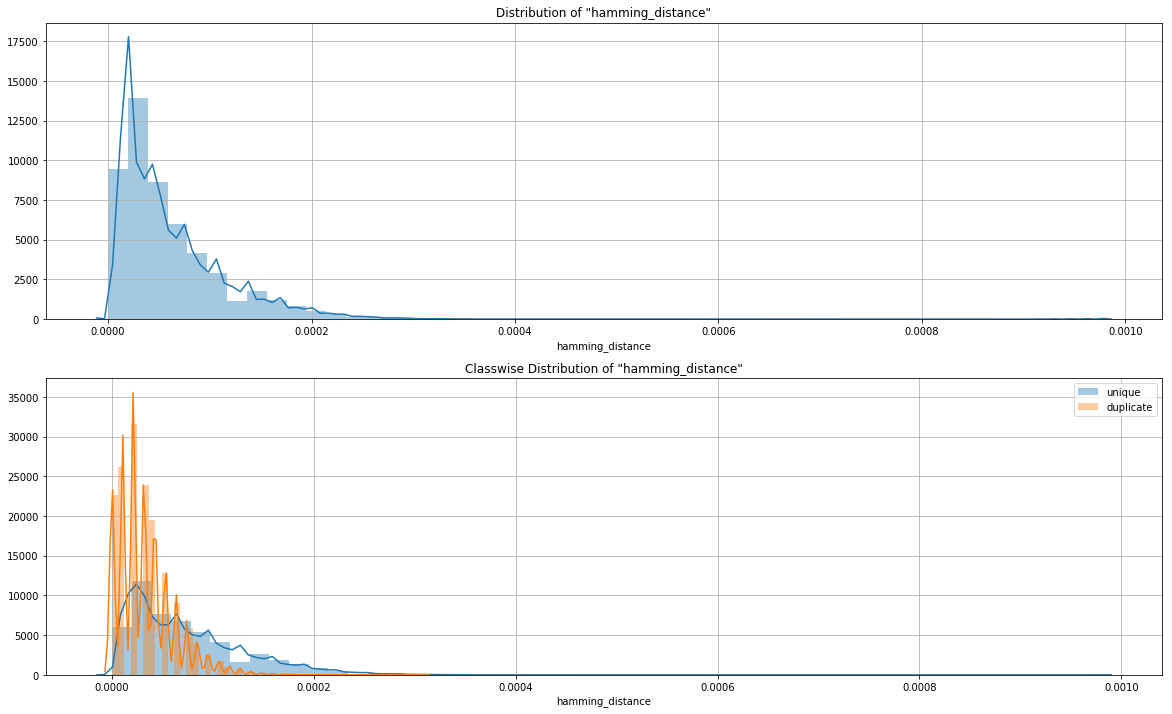

In [12]:
distance = []
for q1, q2 in tqdm(zip(q1_vect, q2_vect)):
    distance.append(hamming(q1.toarray()[0], q2.toarray()[0]))

data['hamming_distance'] = distance

print(feature_distribution(data, 'hamming_distance', 'is_duplicate'))
fig, ax = plot_feature_distribution(data, 'hamming_distance', 'is_duplicate', labels=['unique', 'duplicate'])

___
<center><b>Cosine Distance</b></center>

In [13]:
q1_vect = tv.transform(data['q1_clean'])
q2_vect = tv.transform(data['q2_clean'])


         min  1st  25th  50th  75th  99th  max  mean   std
0       -1.0  0.0  0.28  0.52  0.72  1.00  1.0  0.52  0.29
1       -1.0  0.0  0.11  0.26  0.43  0.76  1.0  0.28  0.20
overall -1.0  0.0  0.20  0.41  0.62  1.00  1.0  0.43  0.28


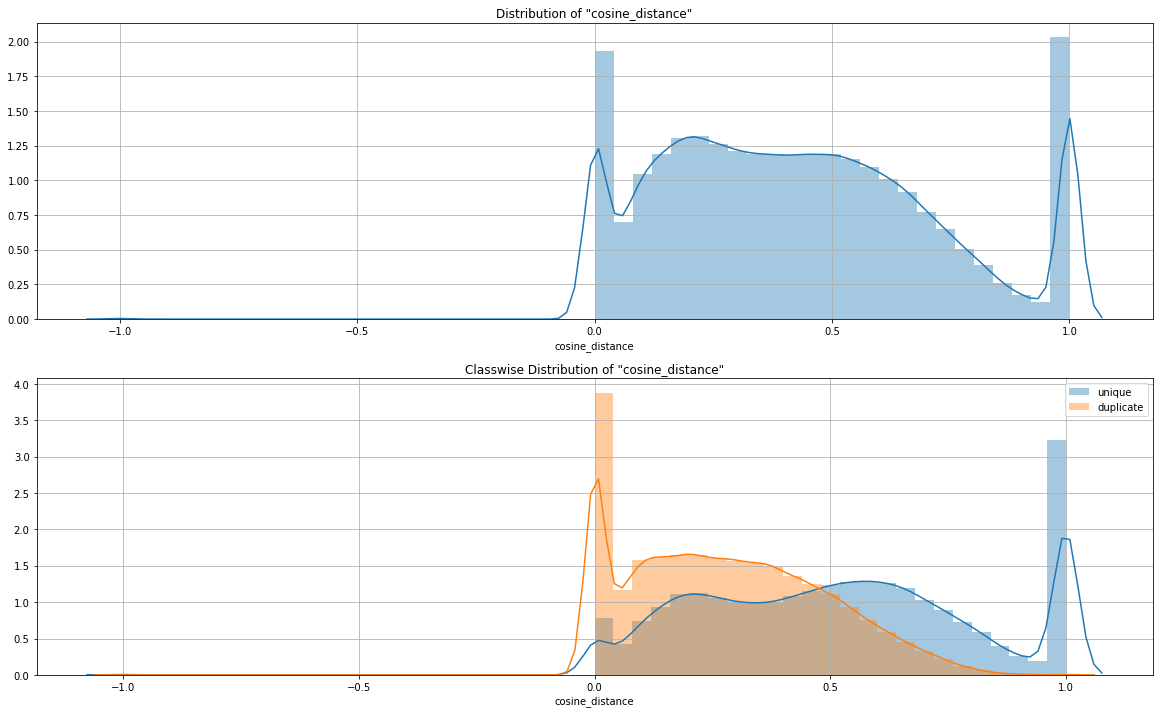

In [14]:
distance = []
for q1, q2 in tqdm(zip(q1_vect, q2_vect)):
    distance.append(cosine(q1.toarray()[0], q2.toarray()[0]))

data['cosine_distance'] = distance
data['cosine_distance'].fillna(-1, inplace=True)
print(feature_distribution(data, 'cosine_distance', 'is_duplicate'))
fig, ax = plot_feature_distribution(data, 'cosine_distance', 'is_duplicate', labels=['unique', 'duplicate'])

___
<center><b>weighted_intersection</b>: weight of unique words common to question1 and question2</center>


         min   1st   25th   50th   75th   99th     max   mean    std
0        0.0  0.00  11.24  17.22  23.51  62.50  189.15  18.10  12.50
1        0.0  5.71  15.84  21.06  27.88  64.81  224.05  23.30  11.64
overall  0.0  0.00  13.11  18.73  25.33  63.29  224.00  20.02  12.44


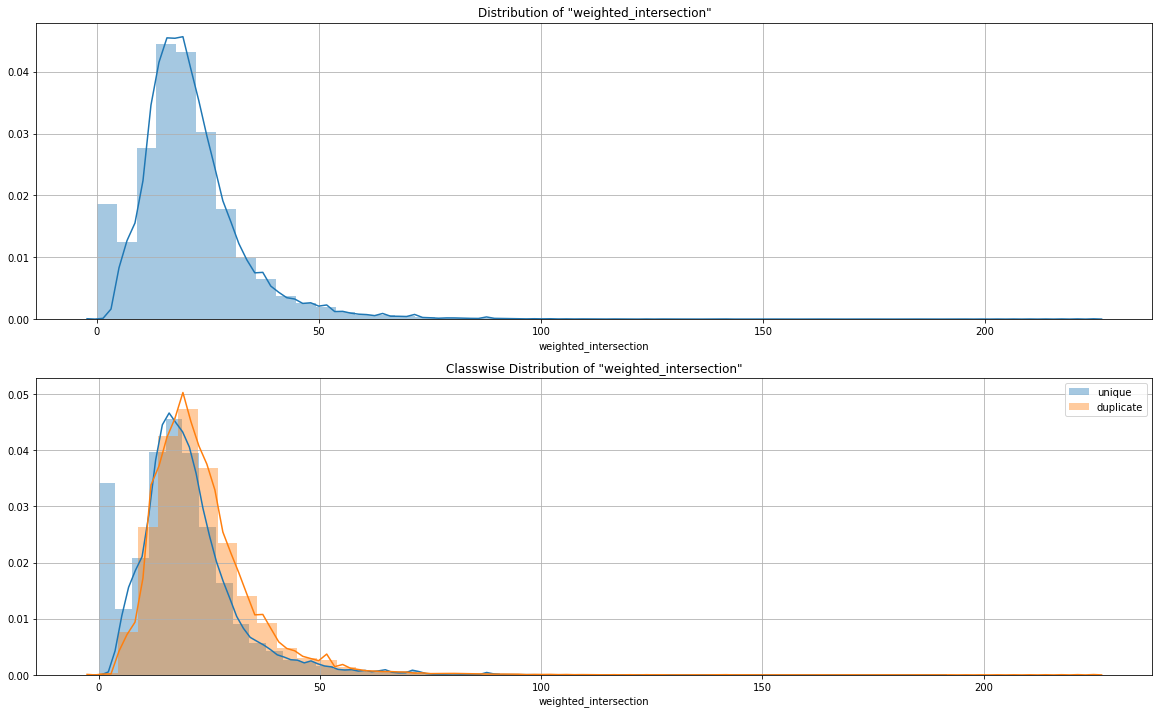

In [15]:
data['weighted_intersection'] = data[['q1_clean', 'q2_clean']].progress_apply(
    lambda row: getweight(set(row['q1_clean'].split())&set(row['q2_clean'].split())),
    axis=1
)

print(feature_distribution(data, 'weighted_intersection', 'is_duplicate'))
fig, ax = plot_feature_distribution(data, 'weighted_intersection', 'is_duplicate', labels=['unique', 'duplicate'])

___
<center><b>weighted_union</b>: weight of unique words in question1 and question2 combined</center>


         min    1st   25th   50th   75th    99th     max   mean    std
0        0.0  13.95  39.97  60.48  88.79  194.90  691.24  69.07  39.75
1        0.0  12.44  28.06  38.75  55.02  122.20  429.59  44.55  23.41
overall  0.0  13.27  33.67  50.62  76.84  181.76  691.00  60.02  36.59


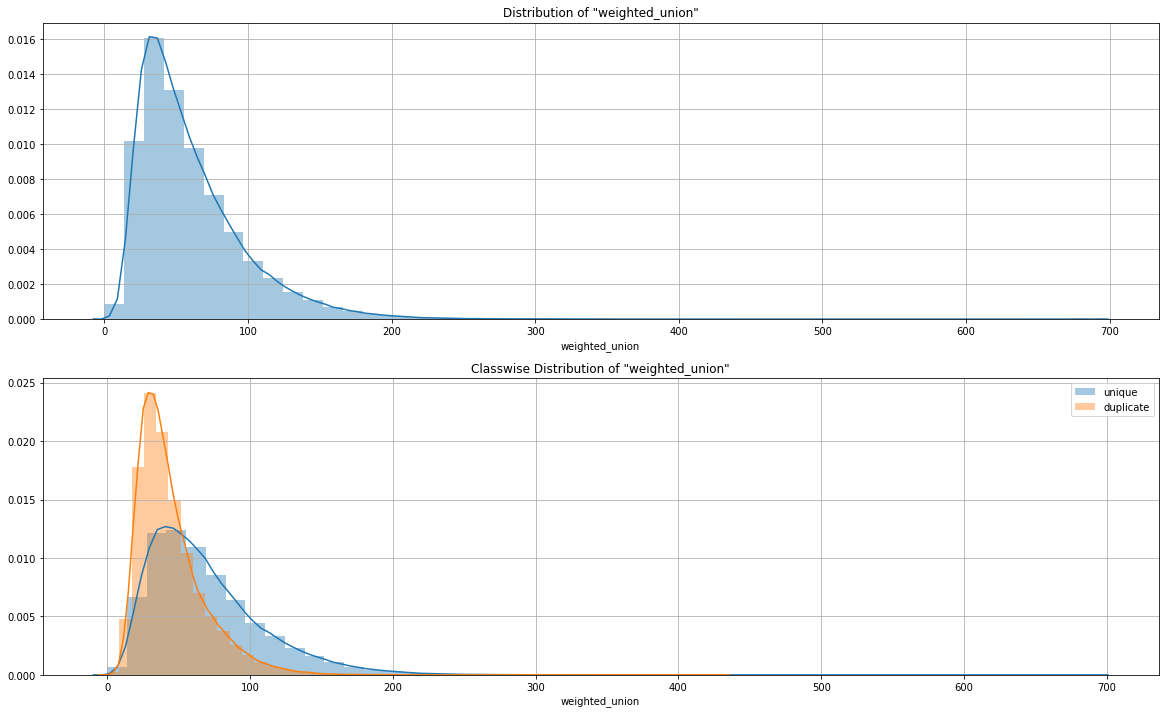

In [16]:
data['weighted_union'] = data[['q1_clean', 'q2_clean']].progress_apply(
    lambda row: getweight(set(row['q1_clean'].split())|set(row['q2_clean'].split())),
    axis=1
)

print(feature_distribution(data, 'weighted_union', 'is_duplicate'))
fig, ax = plot_feature_distribution(data, 'weighted_union', 'is_duplicate', labels=['unique', 'duplicate'])

___
<center><b>jaccard_similarity_weighted</b>: weighted_intersection / weighted_union </center>


         min   1st  25th  50th  75th  99th  max  mean   std
0       -1.0  0.00  0.16  0.31  0.54  1.0   1.0  0.35  0.26
1       -1.0  0.17  0.39  0.55  0.76  1.0   1.0  0.58  0.24
overall -1.0  0.00  0.23  0.41  0.63  1.0   1.0  0.44  0.27


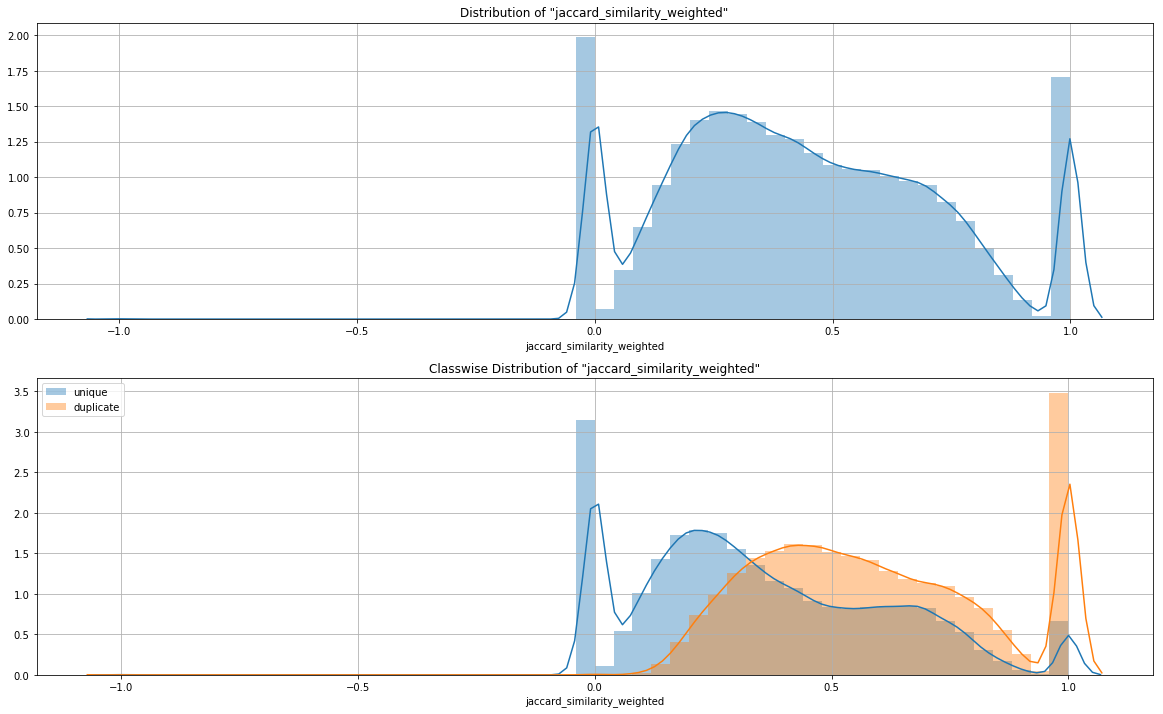

In [17]:
data['jaccard_similarity_weighted'] = data[['weighted_intersection', 'weighted_union']].progress_apply(
    lambda row: row['weighted_intersection']/row['weighted_union'],
    axis=1
)
data['jaccard_similarity_weighted'].fillna(-1, inplace=True)
print(feature_distribution(data, 'jaccard_similarity_weighted', 'is_duplicate'))
fig, ax = plot_feature_distribution(data, 'jaccard_similarity_weighted', 'is_duplicate', labels=['unique', 'duplicate'])

In [18]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,abs_token_diff,avg_num_token,rel_token_diff,token_intersection,token_union,jaccard_similarity_token,...,jaccard_similarity_word,lcs_word,lcs_word_ratio,fuzz_simple_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,hamming_distance,cosine_distance,weighted_intersection,weighted_union,jaccard_similarity_weighted
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,2,13.0,0.153846,10,13,0.769231,...,0.833333,6,0.923077,92,98,92,100,0.000011,0.025243,35.639119,39.982959,0.891358
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,5,10.5,0.476190,4,16,0.250000,...,0.363636,4,0.533333,64,91,62,89,0.000074,0.233014,44.813524,90.737799,0.493879
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,4,12.0,0.333333,3,21,0.142857,...,0.375000,1,0.181818,66,67,71,85,0.000053,0.530295,19.995960,57.294716,0.349002
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,2,10.0,0.200000,0,19,0.000000,...,0.000000,0,0.000000,44,56,15,19,0.000117,1.000000,0.000000,80.610728,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,6,10.0,0.600000,2,18,0.111111,...,0.153846,1,0.133333,52,64,42,53,0.000117,0.764240,14.865222,110.922613,0.134014


In [19]:
feats = ['abs_token_diff', 'avg_num_token', 'rel_token_diff', 
         'token_intersection', 'token_union', 'jaccard_similarity_token',
         'lcs_token', 'lcs_token_ratio',
         'abs_word_diff', 'avg_num_word', 'rel_word_diff',
         'word_intersection', 'word_union', 'jaccard_similarity_word',
         'lcs_word', 'lcs_word_ratio',
         'fuzz_simple_ratio', 'fuzz_partial_ratio', 'fuzz_token_sort_ratio', 'fuzz_token_set_ratio',
         'hamming_distance', 'cosine_distance',
         'weighted_intersection', 'weighted_union', 'jaccard_similarity_weighted',
]
pbc = []
for feat in feats:
    pbc.append(point_biserial_correlation('is_duplicate', feat, data))

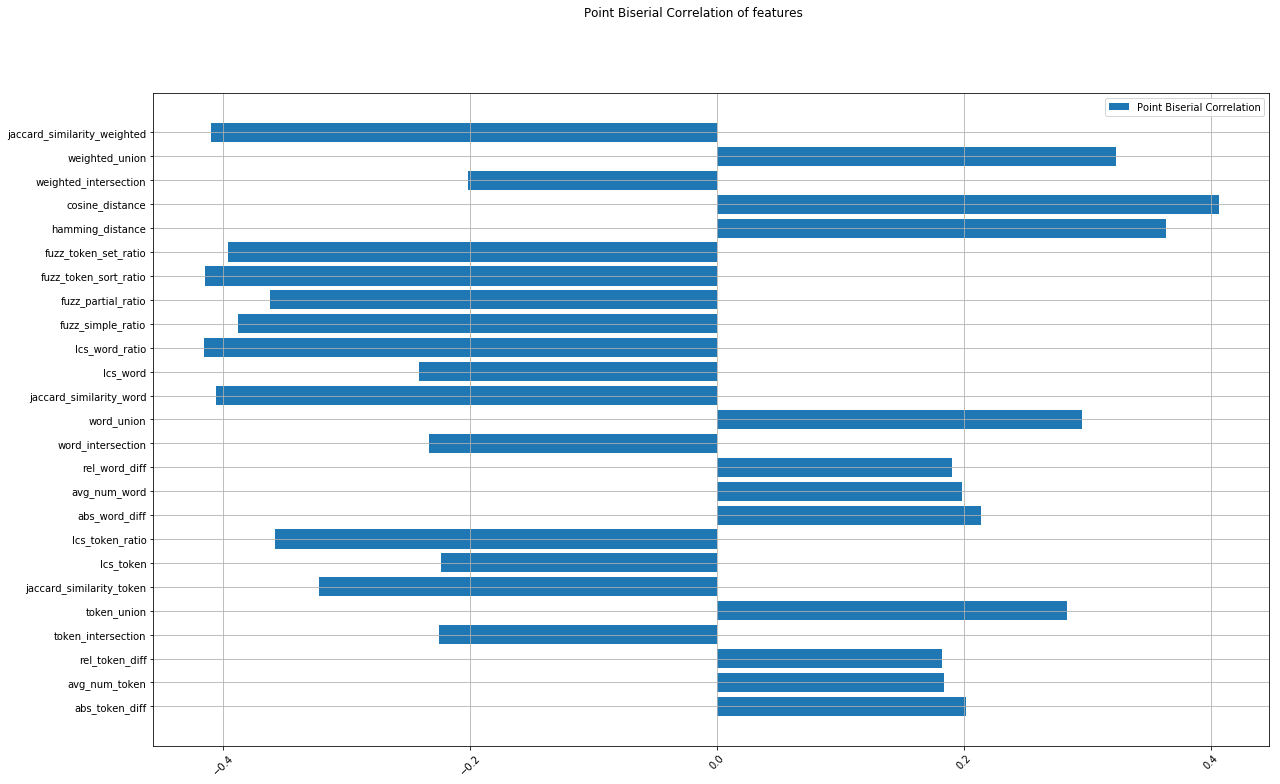

In [20]:
fig, ax = plt.subplots(figsize=(20, 12))
fig.suptitle('Point Biserial Correlation of features')
plt.barh(y=feats, width=pbc)
ax.grid()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend(['Point Biserial Correlation'])

In [21]:
data.to_csv('advanced_features.csv', index=False)

# Model Fitting

In [22]:
from sklearn.linear_model import LogisticRegression

Mean Loss 0.5423273797185223 +- 0.001751678267530737


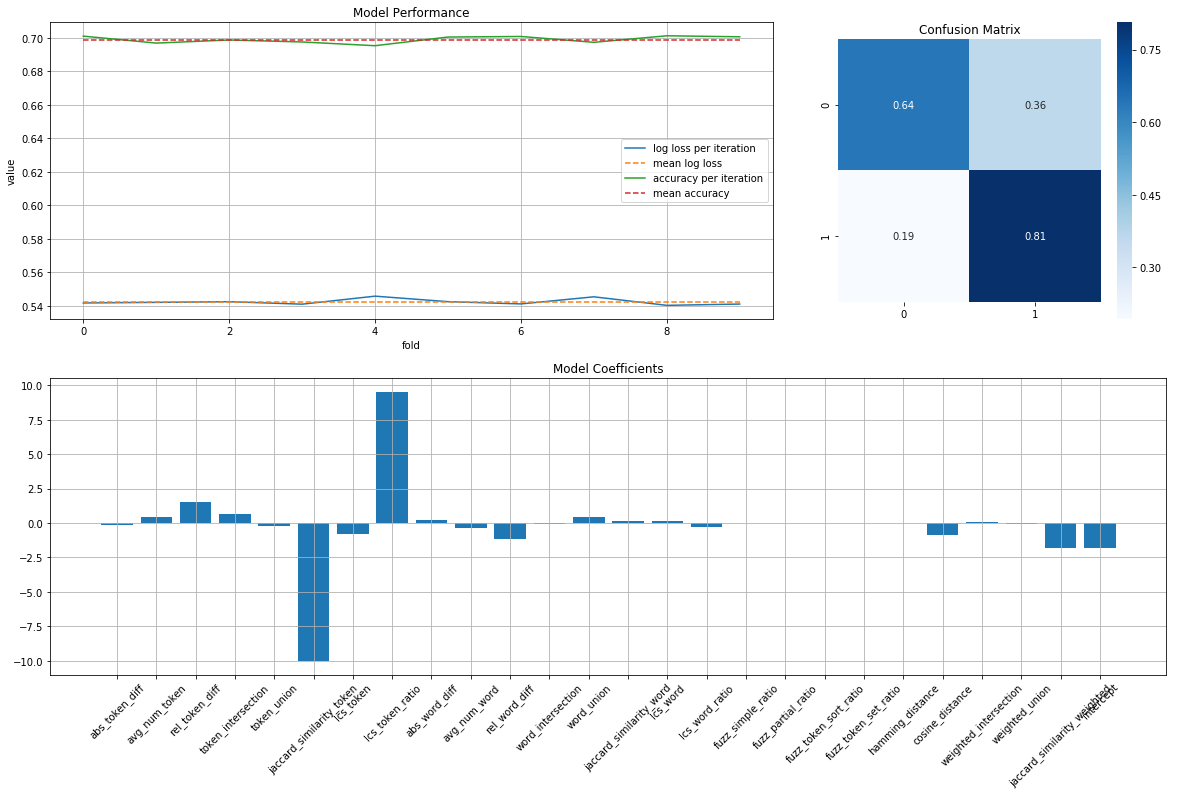

In [23]:
model = LogisticRegression(class_weight='balanced')
lr_performance, lr_cm, lr_model = train_model_lr(model, data, feats, 'is_duplicate')
print('Mean Loss', np.mean(lr_performance['log loss']), '+-', np.std(lr_performance['log loss']))